In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

/Users/mark.obrien/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
data = pd.read_csv('./data/train.csv')
data.describe()

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Category
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,...,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,157.000000,0.140018,0.116428,0.147523,0.166251,0.159290,0.154911,0.171788,0.163420,0.172034,0.171281,0.179636,0.171503,0.174119,0.153835,0.165784,0.166152,0.171364,0.170601,0.181387,0.157154,0.185011,0.196133,0.180824,0.199839,0.222232,0.201880,0.188601,0.234236,0.228543,0.234267,0.253647,0.249130,0.270015,0.268149,0.274300,0.261810,0.273753,0.255111,0.252183,...,0.471302,0.458644,0.459259,0.515054,0.510410,0.522094,0.514067,0.507931,0.523851,0.516204,0.522623,0.492172,0.500018,0.486151,0.500048,0.485192,0.480269,0.493764,0.457243,0.470516,0.457169,0.453815,0.500653,0.469466,0.503876,0.489528,0.525338,0.496356,0.541833,0.548290,0.563733,0.576017,0.572355,0.580488,0.599886,0.639733,0.631687,0.633445,0.670396,0.346667
std,21.794495,0.531072,0.533557,0.515018,0.513822,0.506893,0.501646,0.484376,0.499714,0.497433,0.475007,0.509437,0.501314,0.499924,0.497637,0.521593,0.505443,0.519845,0.514045,0.520197,0.527210,0.524835,0.523491,0.529522,0.556604,0.558099,0.525975,0.558934,0.549806,0.543851,0.556654,0.532007,0.536396,0.545415,0.535172,0.546258,0.537224,0.531428,0.546978,0.541992,...,0.601285,0.618433,0.629102,0.633458,0.642540,0.662866,0.669307,0.669122,0.662788,0.651403,0.668899,0.665471,0.678154,0.684841,0.671306,0.686446,0.688784,0.700168,0.705095,0.678680,0.714091,0.715337,0.720241,0.720421,0.715001,0.731983,0.730160,0.729815,0.743186,0.740354,0.742961,0.740551,0.764901,0.733439,0.786804,0.754772,0.783581,0.783238,0.775564,0.479113
min,120.000000,-1.044003,-0.994305,-0.885585,-0.761513,-0.717464,-0.757696,-0.578701,-0.647595,-0.474244,-0.514474,-0.543553,-0.456491,-0.384420,-0.352567,-0.566997,-0.420144,-0.441520,-0.353757,-0.509204,-0.592152,-0.444914,-0.439701,-0.574872,-0.460629,-0.505096,-0.613136,-0.629044,-0.690151,-0.754038,-0.748604,-0.627966,-0.651720,-0.642458,-0.740451,-0.683785,-0.734745,-0.611053,-0.573446,-0.561694,...,-0.212322,-0.369190,-0.240387,-0.230944,-0.179437,-0.201856,-0.192924,-0.216120,-0.205537,-0.166000,-0.153045,-0.207418,-0.190920,-0.232032,-0.148347,-0.209267,-0.246282,-0.124639,-0.317670,-0.213540,-0.333584,-0.240443,-0.124108,-0.253884,-0.195370,-0.226232,-0.177598,-0.224208,-0.242426,-0.159812,-0.218118,-0.130778,-0.242646,-0.238697,-0.183577,-0.199834,-0.194937,-0.300764,-0.150227,0.000000
25%,138.500000,-0.102221,-0.094447,-0.071158,-0.059394,-0.101118,-0.092047,-0.081801,-0.059817,-0.075092,-0.107051,-0.101056,-0.110884,-0.129692,-0.174610,-0.130503,-0.140260,-0.137652,-0.140055,-0.104224,-0.165503,-0.100441,-0.119135,-0.099495,-0.101648,-0.059165,-0.076273,-0.091618,-0.041292,-0.074539,-0.053982,-0.059092,-0.047185,-0.018341,0.022574,-0.034751,0.006820,-0.034022,-0.055871,-0.041966,...,0.026988,0.023114,-0.003215,0.082658,0.050069,0.028807,0.010785,0.021161,0.031642,0.049391,0.029853,-0.003782,0.002602,-0.001718,0.020833,-0.014914,0.018419,-0.004423,0.000542,-0.003641,-0.012137,-0.009983,0.006118,-0.026508,0.030370,0.012968,0.026323,-0.031505,0.022161,0.0

In [4]:
data.head(10)

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Category
0,120,0.147298,-0.142030,0.091737,-0.151707,0.060124,0.186191,-0.021298,-0.025636,0.061044,-0.032940,0.181828,0.019219,-0.032017,-0.054029,-0.093295,-0.062775,-0.035067,-0.048764,-0.065818,0.209884,-0.103010,0.014663,0.059252,0.063011,-0.005861,-0.024070,0.045155,0.026652,-0.025896,-0.156188,-0.046792,-0.114655,-0.066716,0.003322,0.035874,0.178045,-0.053741,0.077463,0.030596,...,-0.051111,-0.363520,0.209210,0.055056,-0.076735,-0.112466,-0.049565,0.071688,-0.189208,-0.014158,0.177064,-0.113395,0.008039,0.220331,0.063215,0.012592,0.050664,-0.040087,0.129963,-0.039933,-0.195918,-0.039130,-0.096673,-0.028119,-0.025908,0.119742,0.069529,0.026327,-0.000295,-0.105886,-0.218118,0.011316,0.079464,-0.010833,-0.053485,0.046450,-0.008333,0.168574,0.123273,0
1,121,0.115710,0.105061,0.038446,0.166711,-0.113913,0.004528,-0.006954,-0.140054,0.154231,-0.150152,-0.091541,0.040798,-0.000882,-0.189423,-0.020635,-0.066971,0.133756,-0.059153,-0.110073,-0.174534,-0.153030,-0.148063,0.087110,-0.030910,0.042293,0.156183,-0.212271,0.169429,0.063545,0.115878,0.001285,0.017324,0.147077,0.338460,0.198524,0.219389,0.064925,0.012353,-0.020075,...,-0.066628,-0.010276,-0.002572,0.097139,0.204940,0.065201,-0.127060,0.073919,0.068506,0.049881,-0.004740,0.063285,0.030190,0.002275,0.027033,-0.075690,-0.098659,0.072526,-0.022670,-0.006189,0.026661,-0.046953,-0.006708,-0.253884,-0.068468,-0.096877,0.102282,0.042765,-0.095751,0.023048,0.021526,0.069009,-0.060343,0.094007,0.049558,0.112370,0.020398,0.039687,0.217384,0
2,122,-0.548826,-0.466551,-0.650890,-0.553450,-0.449101,-0.496902,-0.464860,-0.394458,-0.271801,-0.349482,-0.187094,-0.375930,-0.384420,-0.052084,-0.299203,-0.357346,-0.398493,-0.120857,-0.272999,-0.280711,-0.292155,-0.197570,-0.337605,-0.100293,-0.327176,-0.228796,-0.236946,-0.293044,-0.312339,-0.180732,-0.123022,-0.194350,-0.088549,0.044384,0.147797,0.041080,0.152591,-0.089055,0.049464,...,0.228661,0.059073,0.128650,0.021256,0.183462,0.256512,0.070785,-0.080579,-0.035184,0.048901,0.067367,0.092570,0.069757,0.025446,-0.037862,0.066882,0.213277,0.130781,0.083268,0.133765,-0.005288,-0.017998,-0.040940,0.022320,-0.006342,0.157696,-0.009654,-0.041383,0.234157,-0.004228,0.057272,0.088062,-0.069730,0.168498,0.109672,0.202808,-0.019942,0.058902,0.053936,0
3,123,0.192618,0.291155,-0.042980,0.146483,0.015390,0.019394,-0.005577,-0.048682,0.025772,-0.079145,0.014541,-0.032802,-0.065138,-0.143099,-0.118278,0.009893,-0.017132,-0.162959,-0.049652,0.024639,-0.205142,0.031274,-0.071818,0.070818,-0.042073,-0.125225,-0.086653,0.100895,0.140544,0.040528,0.208591,-0.010689,0.156231,0.045565,0.101696,0.168284,0.070811,0.108665,0.235403,...,0.388778,0.284738,0.178796,0.342251,0.188698,0.029521,0.132738,0.043131,0.188368,0.215629,0.369084,0.219689,0.149141,0.237194,-0.083830,0.144390,0.182642,-0.055769,0.195366,0.106582,0.026158,0.129388,0.295199,0.091934,0.107656,0.049196,0.025287,0.210811,0.061483,0.174743,0.140831,0.257332,0.262786,0.351659,0.213291,0.251077,0.190920,0.251743,0.337730,1
4,124,0.075706,0.069045,-0.019818,0.068801,-0.226501,0.011658,0.087905,-0.080787,-0.080369,-0.182513,0.164091,-0.065843,0.031451,0.069013,0.161206,-0.003911,-0.040883,0.032050,0.144937,0.001399,-0.075081,-0.131578,-0.097438,0.113426,-0.002678,-0.028868,-0.037110,0.045695,0.016050,0.015591,0.180846,0.202827,-0.108763,0.088315,-0.018713,0.037669,0.097044,0.048568,0.096712,...,0.408251,0.099536,0.186293,0.234779,0.186673,0.193219,0.271190,0.388516,0.319634,0.397826,0.152506,0.296199,0.287385,0.314468,0.424584,0.272585,0.261919,0.363775,0.140566,0.302812,0.321291,0.250990,0.457150,0.253739,0.354998,0.406624,0.521479,0.394006,0.497707,0.483283,0.434803,0.322841,0.297772,0.461421,0.406143,0.562082,0.554588,0.471489,0.384229,1
5,125,1.081769,0.986722,1.067524,

In [5]:
data.shape

(75, 102)

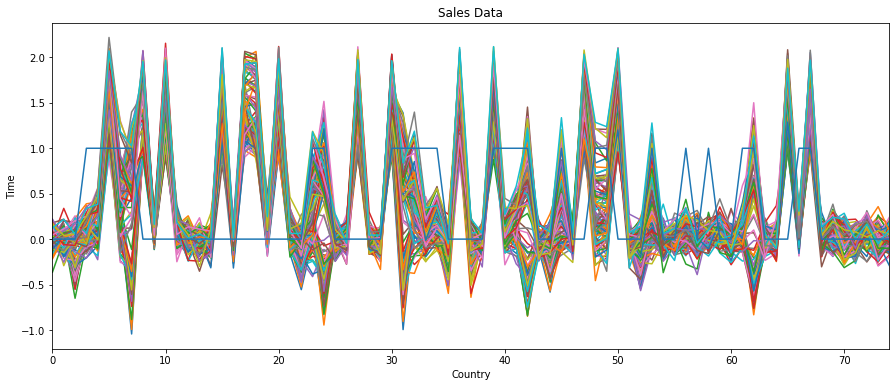

In [6]:
ax = data.loc[:, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

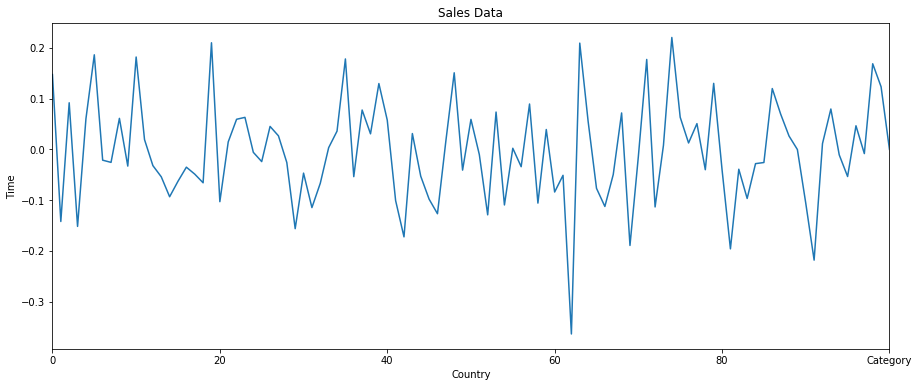

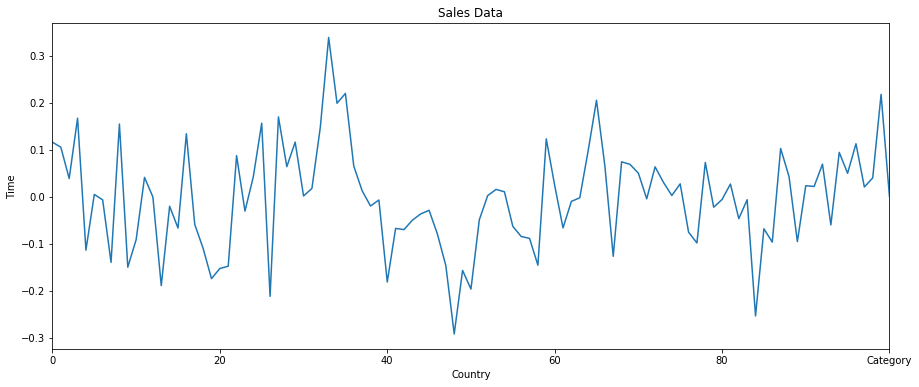

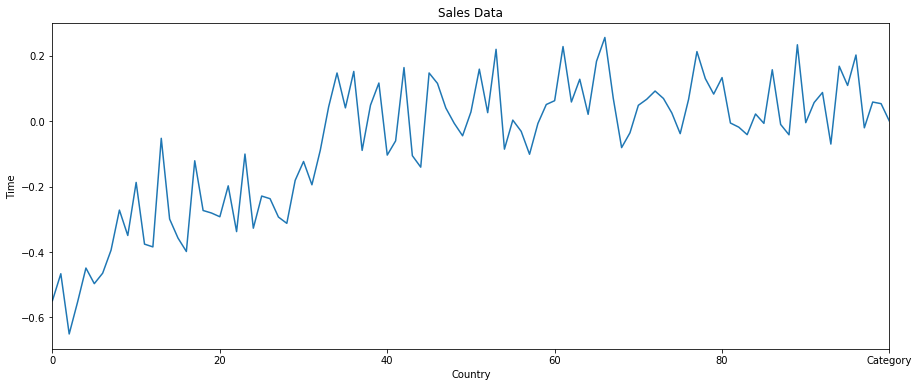

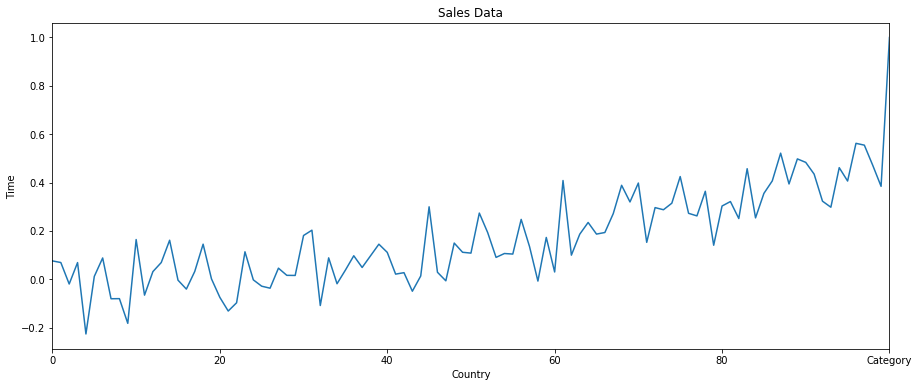

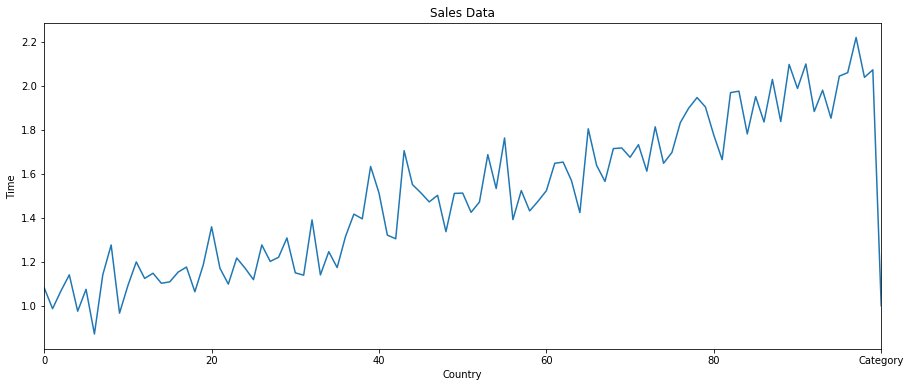

In [7]:
ax = data.iloc[0, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

ax = data.iloc[1, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

ax = data.iloc[2, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

ax = data.iloc[4, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

ax = data.iloc[5, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

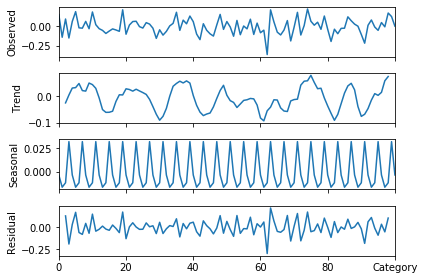

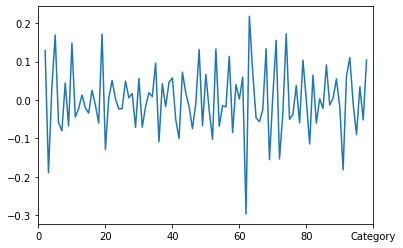

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(data.iloc[0, data.columns != 'Id'], model='additive', freq=1)
# result.plot()
# plt.show()

# result = seasonal_decompose(data.iloc[0, data.columns != 'Id'], model='additive', freq=2)
# result.plot()
# plt.show()

# result = seasonal_decompose(data.iloc[0, data.columns != 'Id'], model='additive', freq=4)
# result.plot()
# plt.show()

# result = seasonal_decompose(data.iloc[0, data.columns != 'Id'], model='additive', freq=8)
# result.plot()
# plt.show()

result = seasonal_decompose(data.iloc[0, data.columns != 'Id'], model='additive', freq=4)
result.plot()
plt.show()

result.resid.plot()
plt.show()

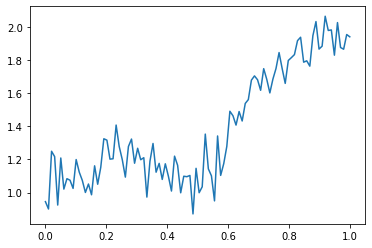

In [6]:
X = np.linspace(0,1,100)
Y = data.iloc[18,1:101].values
X = X[:, None]
Y = Y[:, None]
plt.plot(X,Y)

In [ ]:
with pm.Model() as model:
    #  periodic component x 
    η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
    ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

    cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

    #  linear component x 
    cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2.
    gp = gp1 + gp2

    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
    f = gp.marginal_likelihood("f", X, Y[:,0], noise=sigma)

    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

In [ ]:
#optimized parameters
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

In [ ]:
# 200 new values from x=0 to x=3
n_new = 100
X_new = np.linspace(0, 1, n_new)[:,None]

#periodic term
f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#linear term
f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#sum of periodic and linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})

#we sample 10 regression lines from the posterior
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

In [ ]:
#we can recover the single components
plt.plot(X_new[:,0],f1_pred[0], color="blue")
plt.plot(X_new[:,0],f2_pred[0], color="red")

In [ ]:
f2_pred[0]

In [ ]:
plt.plot(X_new[:,0],f2_pred[1][88])

In [ ]:
def run_model(x_in, y_in, plot=False):
    with pm.Model() as model:
        #  periodic component x 
        η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
        ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

        cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

        #  linear component x 
        cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp2 = pm.gp.Marginal(cov_func=cov_linear)

        # gp represents f1 + f2.
        gp = gp1 + gp2

        # noise model
        sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
        f = gp.marginal_likelihood("f", x_in, y_in[:,0], noise=sigma)

        # this line calls an optimizer to optimize the marginal likelihood
        mp = pm.find_MAP(include_transformed=True)

    # 200 new values from x=0 to x=3
    n_new = 100
    X_new = np.linspace(0, 1, n_new)[:,None]

    #periodic term
    f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #linear term
    f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #sum of periodic and linear term
    y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[0],X_new[:,0])>0)[0])/len(f2_pred[0])
    
    print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.8:
        return 1
    else:
        return 0

In [ ]:
test_df = pd.read_csv('./data/test.csv')
test_df.head()

In [ ]:
x = np.linspace(0,1,100)[:,None]
Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(test_df.shape[0]):
    id_row = test_df.iloc[r,0]
    y = test_df.iloc[r,1:101].values[:,None]
    decision = run_model(x,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    print(Decision)

Decision.to_csv('submission_1.csv')

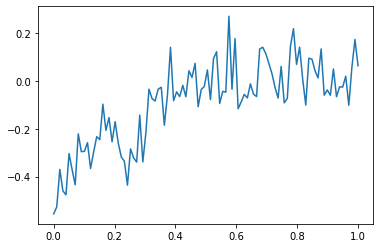

In [167]:
X = np.linspace(0,1,100)
Y = data.iloc[22,1:101].values
X = X[:, None]
Y = Y[:, None]
plt.plot(X,Y)

Optimization restart 1/5, f = -87.18843694183937
Optimization restart 2/5, f = -85.77408580414154
Optimization restart 3/5, f = -30.352581451013684
Optimization restart 4/5, f = -86.88506630641493
Optimization restart 5/5, f = -86.39819797002565


GP_regression.,value,constraints,priors
mul.periodic_exponential.variance,13.536916394344754,+ve,
mul.periodic_exponential.lengthscale,1082.0575655431214,+ve,
mul.periodic_exponential.period,5.808653095704423,+ve,
mul.periodic_Matern52.variance,17.12833539756962,+ve,
mul.periodic_Matern52.lengthscale,4.84327899556458,+ve,
mul.periodic_Matern52.period,9.27812151697839,+ve,
mul.Exponential.variance,13.536916394969781,+ve,
mul.Exponential.lengthscale,0.8937131747303745,+ve,
Gaussian_noise.variance,0.006471959980430248,+ve,


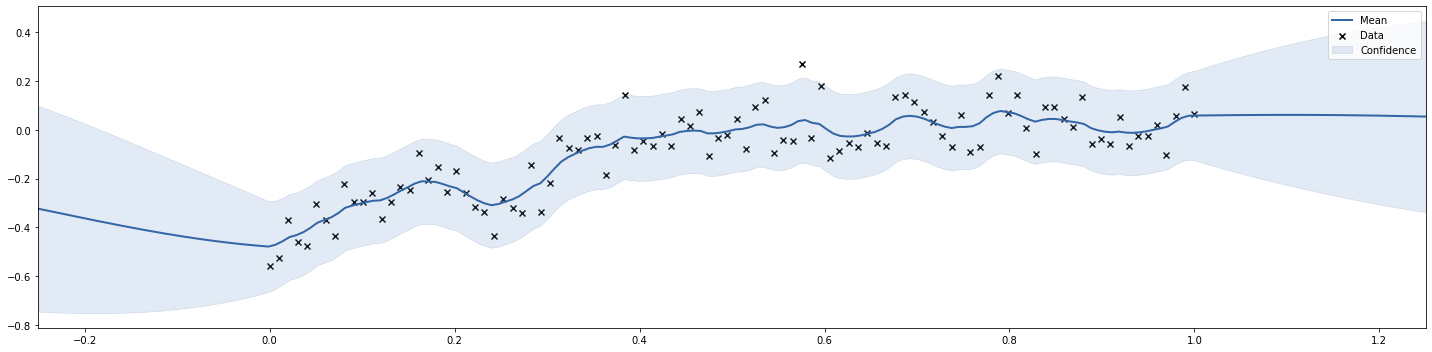

In [253]:
import GPy as GPy

ker3 = GPy.kern.PeriodicExponential(1,1.,2.)
ker4 = GPy.kern.PeriodicMatern52(1, 0.5, 0.2)
ker6 = GPy.kern.Exponential(1)

ker_p = ker3
ker_t = ker4*ker6
kernel = ker_p*ker_t

# create a GP model
g_model = GPy.models.GPRegression(X,Y,kernel=kernel)

# it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
g_model.optimize_restarts(5)# this maximise the marginal likelihood, with random restarts
#we  plot it
fig = g_model.plot(figsize=(20,5))
display(g_model)

In [245]:
X_test = X
X_test = X_test.reshape(-1,1)

In [86]:
f2_pred, sigm2_pred = g_model.predict(X_test, kern=kernel)

In [87]:
posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[:,0],X_test[:,0])>0)[0])/len(f2_pred[:,0])
    
print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
if posterior_probability_deriviative_is_positive>0.8:
    print("1")
else:
    print("0")

Probability Sales Increasing is:  0.53
0


In [15]:
data['Category'][0]

0

# Notes
* Test 1 - Used RBF & Matern32
 * Definitely don't use RBF as selected kernel
 * Removing linespace=100 improved the accuracy to 0.6 selecting Matern32
* Test 2 - Used RBF & Poly order = 3. Selected Poly
 * Worse - dropped to 0.5
* Test 3 - Used RBF & PeriodicExponential. Selected PeriodicExponential
 * Improved to 0.75
 * Increased to predict against 30 countries from 20 - Reduced to 73
 * Increased to predict against 50 countries from 30 - Reduced to 68
 * Increased optimize restarts from 5 to 10 - No change still 66
* Test 4 - RBF, PeriodicExponential, White
 * Had zero effect - probably because white looks like a zero based function
* Test 5 - ExpQuad, PeriodicExponential, Matern52. Selected ExpQuad
 * Typical 60% accuracy
* Test 6 - RBF, PeriodicExponential, Poly
 * Typical 60%
* Test 7 - ExpQuad, PeriodicMatern52, Linear, Poly
 * Thinking here was that a linear function may help identify the trend without the noise affecting it
 * Not sure exactly why I'm thinking this
 * didn't work, promising at smaller numbers of samples, got worse as I increased number of countries

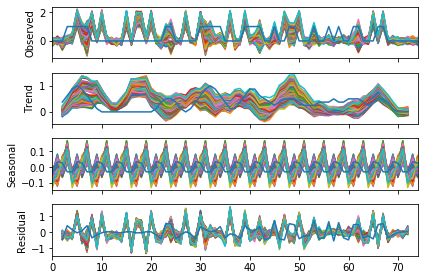

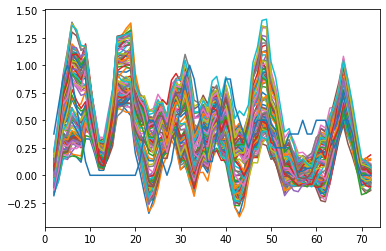

In [456]:
result = seasonal_decompose(data.loc[:, data.columns != 'Id'], model='additive', freq=4)
result.plot()
plt.show()

res = result.trend
res.plot(legend=False)
plt.show()

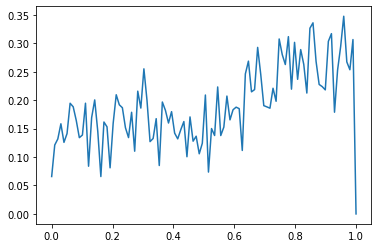

In [457]:
X = np.linspace(0,1,100)
Y = res.iloc[12,1:101].values
X = X[:, None]
Y = Y[:, None]
plt.plot(X,Y)

In [474]:
rows = res.shape[0] - 30
actual = data.head(rows)['Category']

print(res.shape)
print(rows)
print(actual.shape[0])

(75, 101)
45
45


In [475]:
import GPy as GPy
# Tomorrow take a look at this
# file:///Users/mark.obrien/Downloads/Master%20Thesis%20Bagas%20Abisena%20Swastanto%204415345.pdf
def run_model_2(x_in, y_in):
    ker1 = GPy.kern.PeriodicExponential(1)
    ker2 = GPy.kern.Linear(1, ARD=True)
    ker3 = GPy.kern.Matern52(1, variance=.3, lengthscale=1.2, ARD=True, active_dims=0)
    ker1 = GPy.kern.PeriodicExponential(
        1, 
        variance=.5, 
        lengthscale=1,
        period=6.283185307179586, 
        n_freq=12, 
        lower=0.0, 
        upper=12.566370614359172, 
        active_dims=0)
#     ker2 = GPy.kern.Linear(1, ARD=True)
#     ker3 = GPy.kern.Matern32(1, variance=.4, lengthscale=1, ARD=True, active_dims=0)
    
    ker_p = ker1
    ker_t = ker2*ker3
    kernel = ker1

    # create a GP model
    g_model = GPy.models.GPRegression(x_in,y_in,kernel=kernel)
    
    # it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
    g_model.optimize_restarts(5, robust=True, verbose=False, parallel=True, num_processes=12)# this maximise the marginal
    
    X_test = x
    X_test = X_test.reshape(-1,1)
    
    f2_pred, sigm2_pred = g_model.predict(X_test, kern=kernel)
        
    plt.title('Prediction Plot')
    plt.plot(x_in[:,0],f2_pred)
    plt.show()
    
    kernel.plot()
    plt.show()
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[:,0],X_test[:,0])>0)[0])/len(f2_pred[:,0])
    
    #print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.8:
        return 1
    else:
        return 0

Iteration: 0 of 45


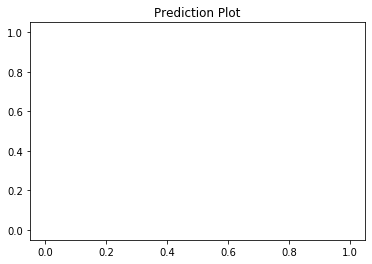

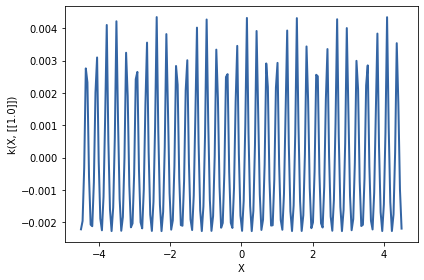

Iteration: 1 of 45


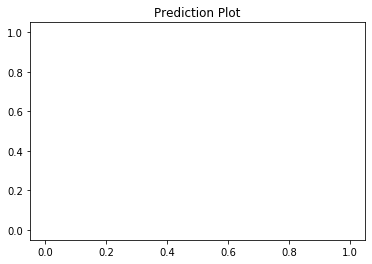

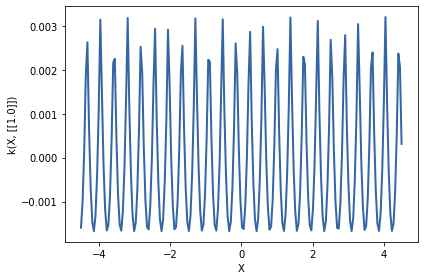

Iteration: 2 of 45


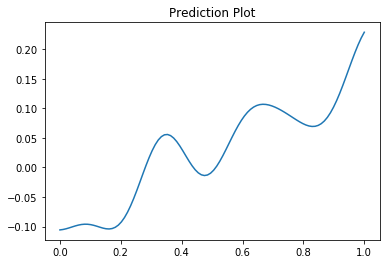

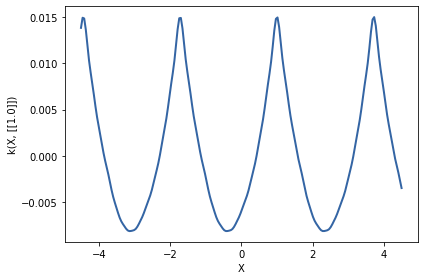

Iteration: 3 of 45


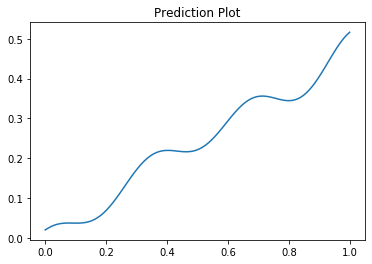

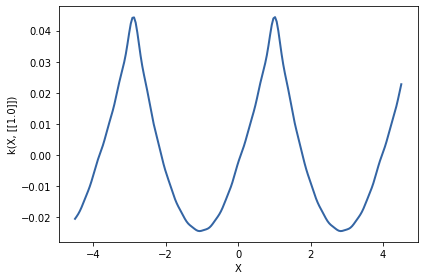

Iteration: 4 of 45


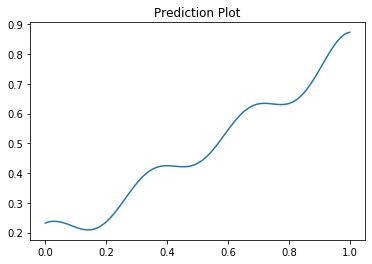

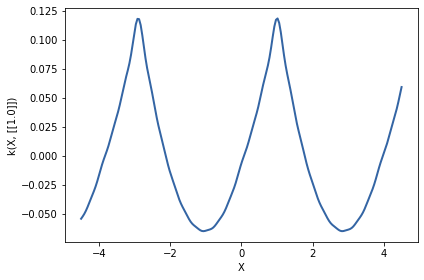

Iteration: 5 of 45


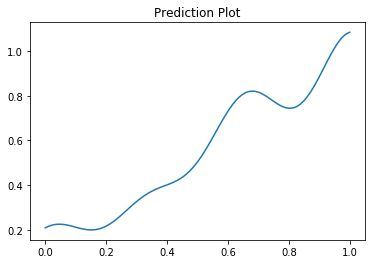

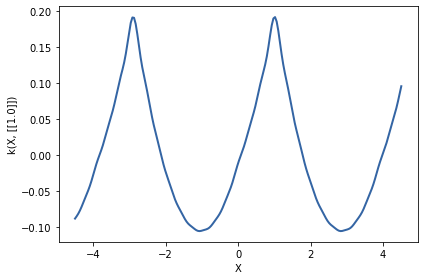

Iteration: 6 of 45


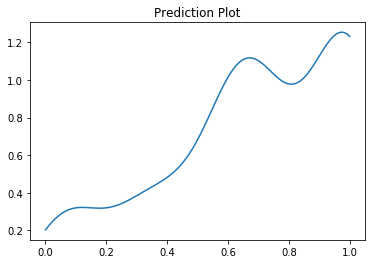

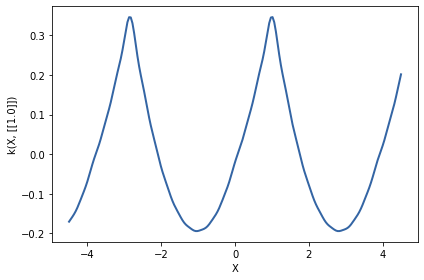

Iteration: 7 of 45


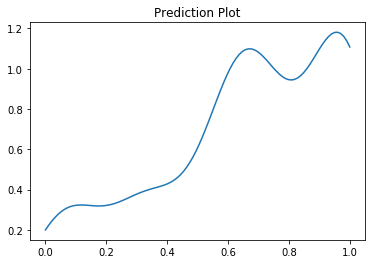

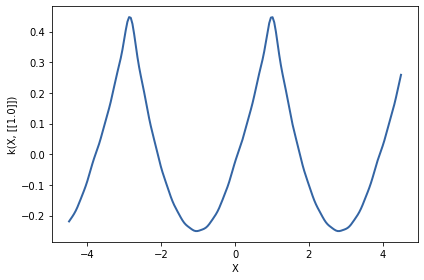

Iteration: 8 of 45


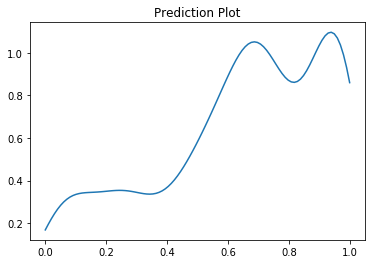

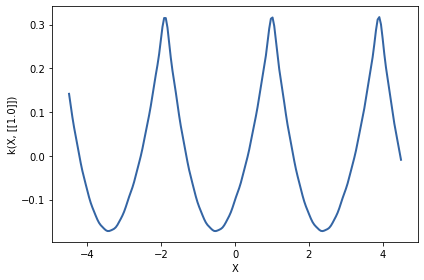

Iteration: 9 of 45


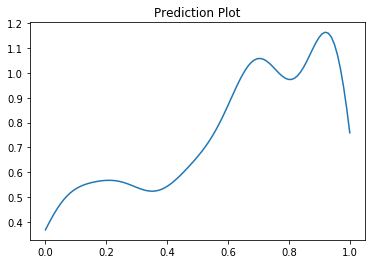

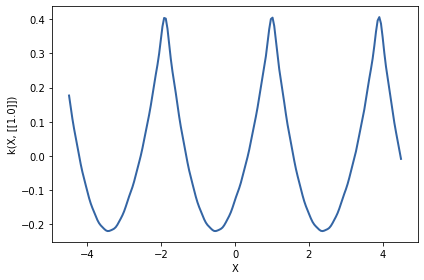

Iteration: 10 of 45


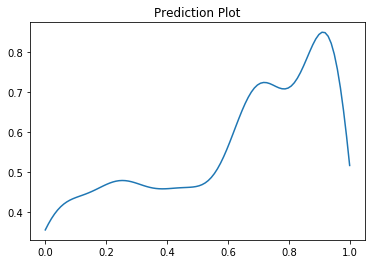

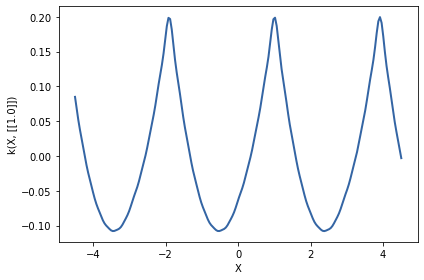

Iteration: 11 of 45


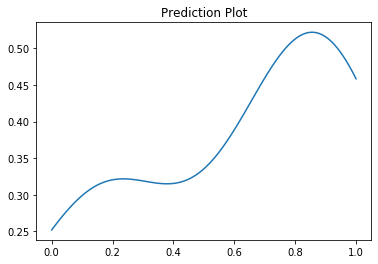

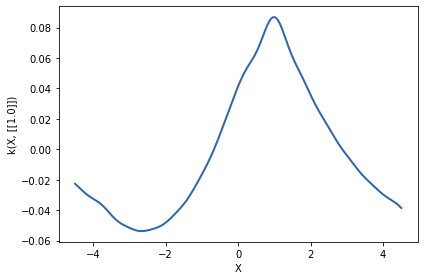

Iteration: 12 of 45


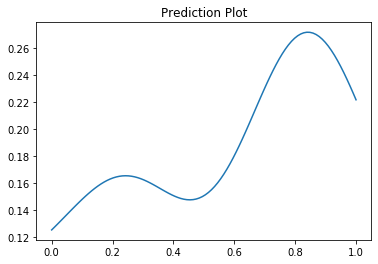

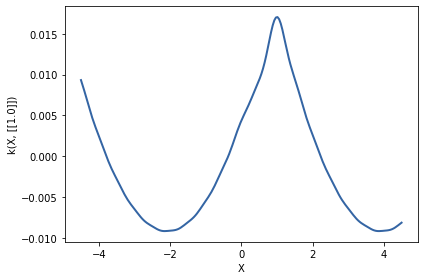

Iteration: 13 of 45


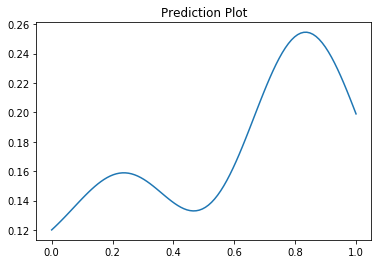

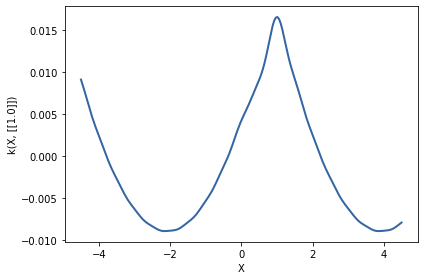

Iteration: 14 of 45


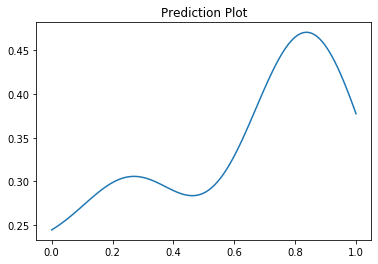

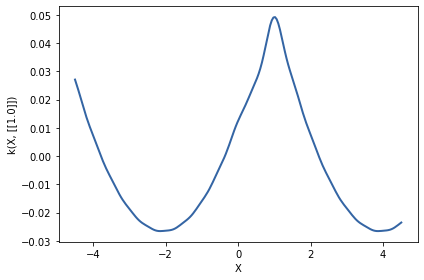

Iteration: 15 of 45


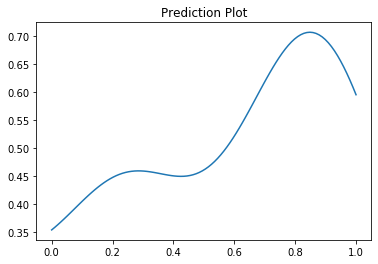

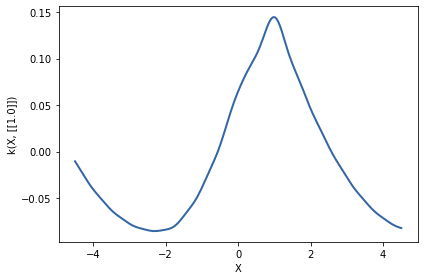

Iteration: 16 of 45


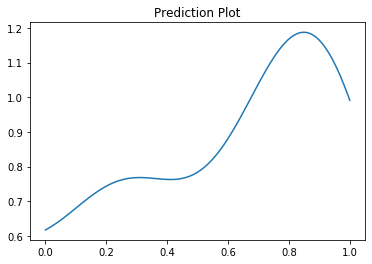

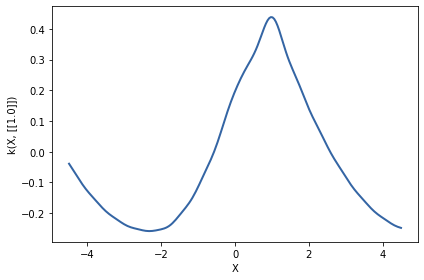

Iteration: 17 of 45


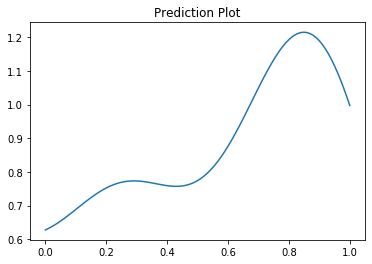

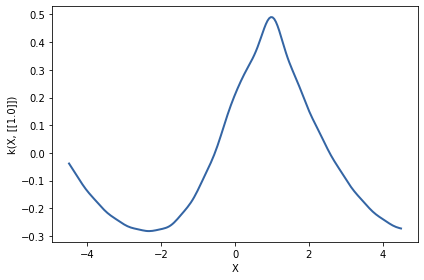

Iteration: 18 of 45


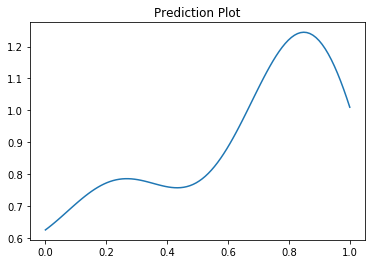

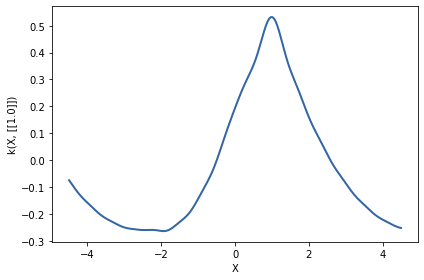

Iteration: 19 of 45


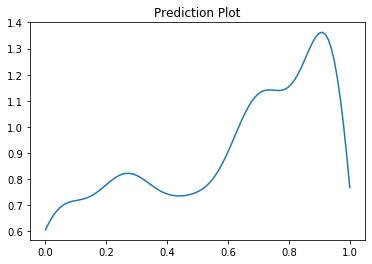

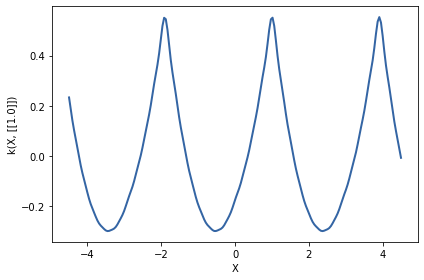

Iteration: 20 of 45


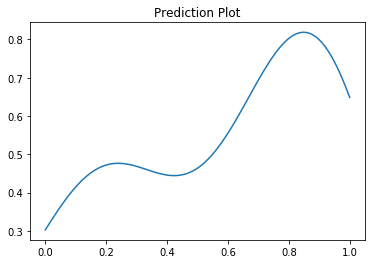

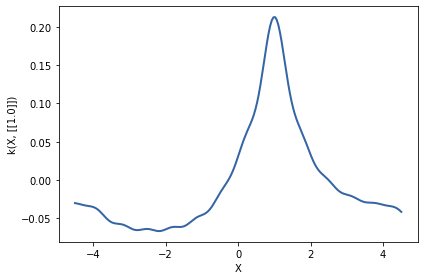

Iteration: 21 of 45


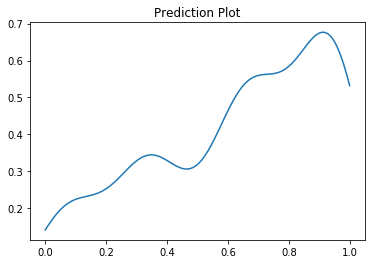

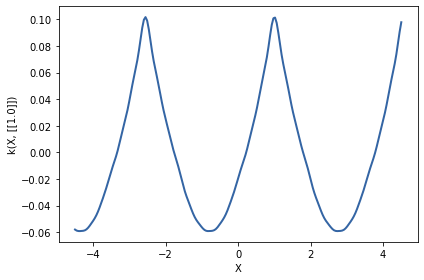

Iteration: 22 of 45


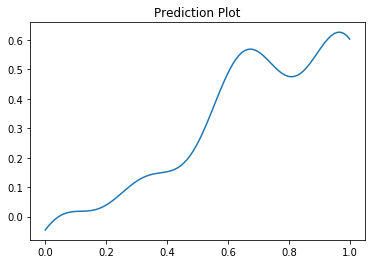

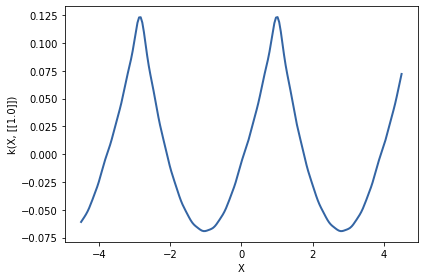

Iteration: 23 of 45


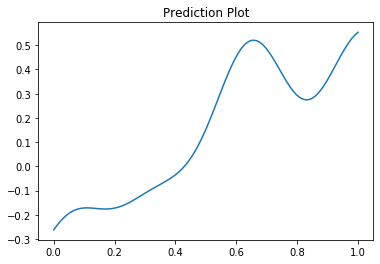

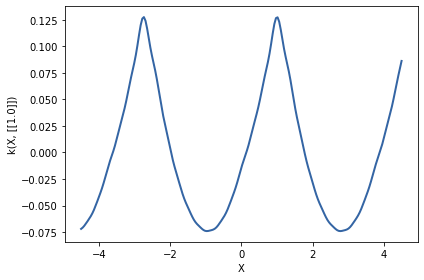

Iteration: 24 of 45


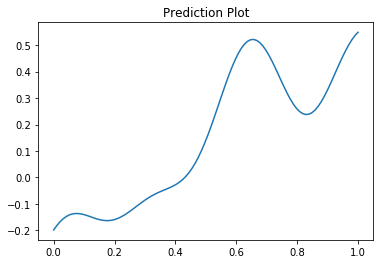

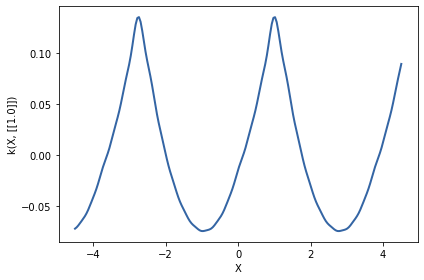

Iteration: 25 of 45


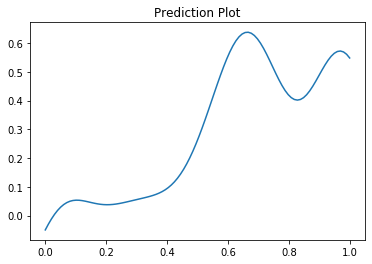

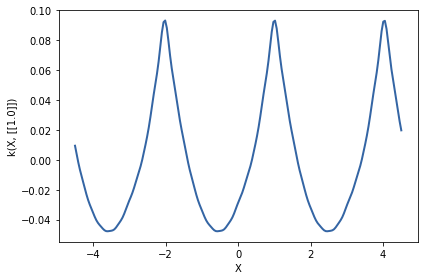

Iteration: 26 of 45


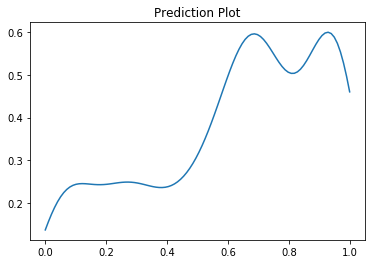

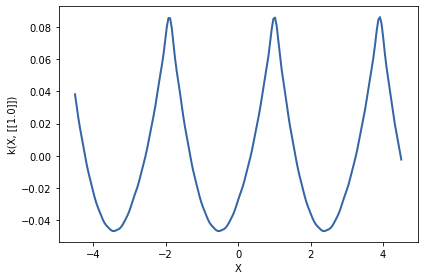

Iteration: 27 of 45


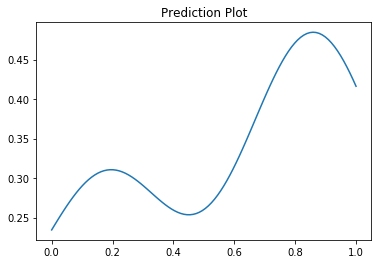

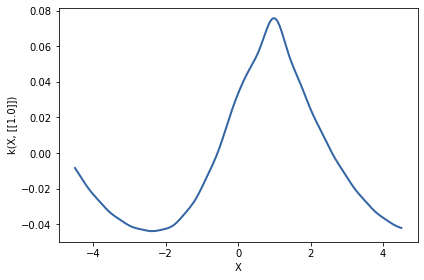

Iteration: 28 of 45


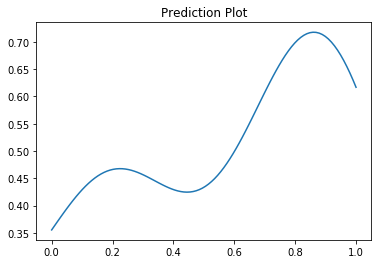

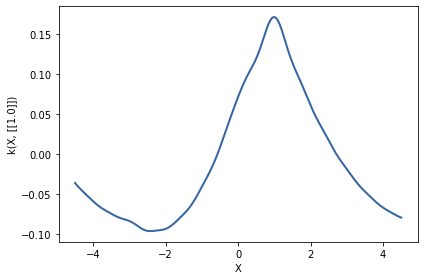

Iteration: 29 of 45


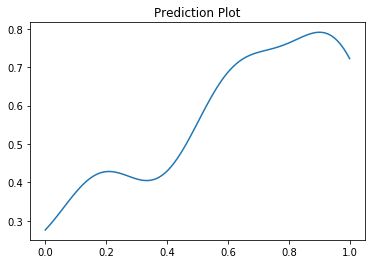

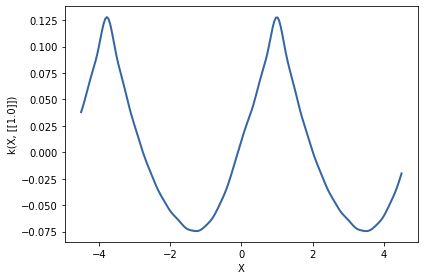

Iteration: 30 of 45


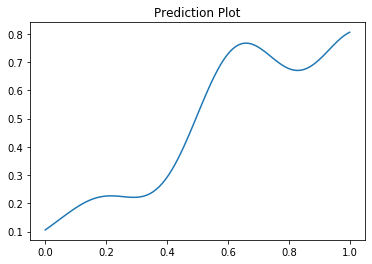

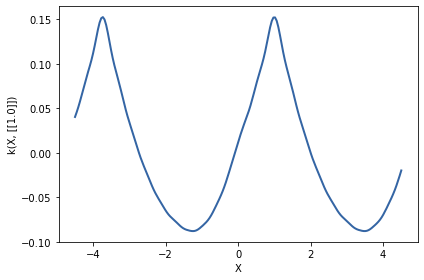

Iteration: 31 of 45


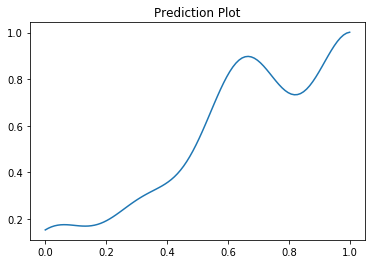

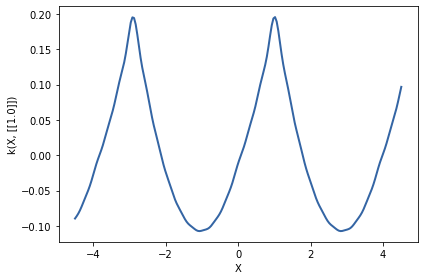

Iteration: 32 of 45


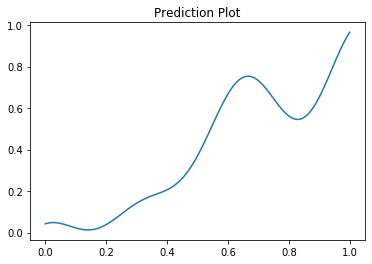

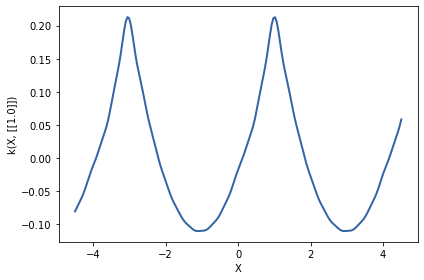

Iteration: 33 of 45


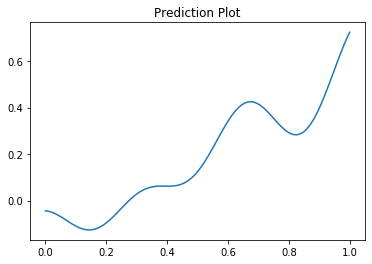

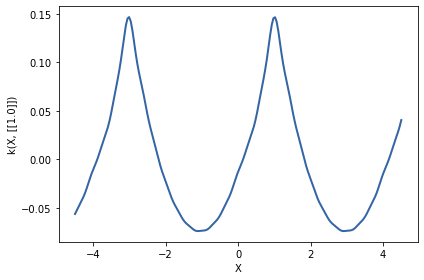

Iteration: 34 of 45


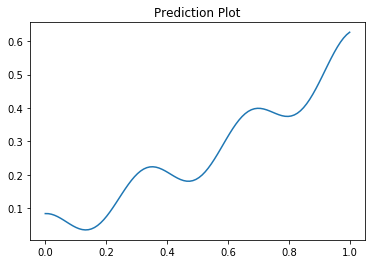

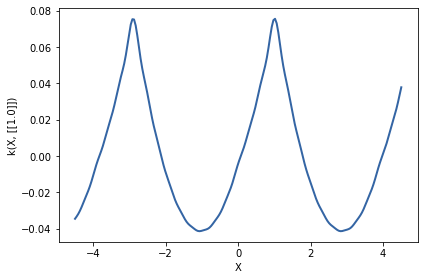

Iteration: 35 of 45


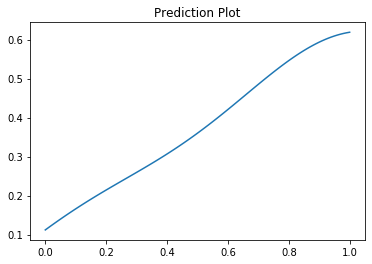

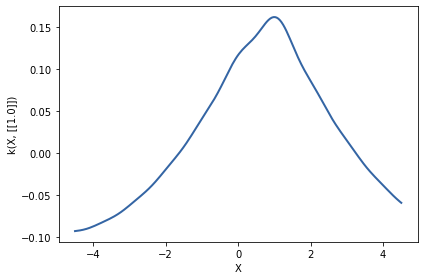

Iteration: 36 of 45


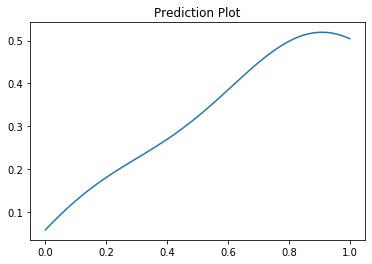

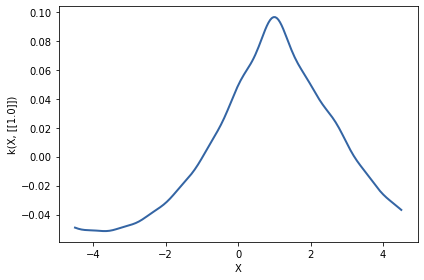

Iteration: 37 of 45


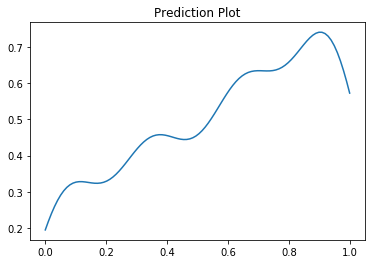

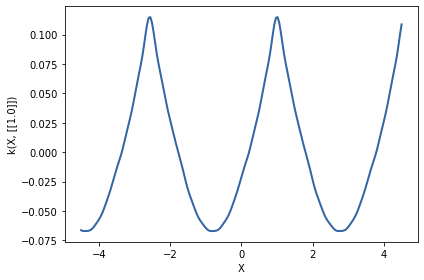

Iteration: 38 of 45


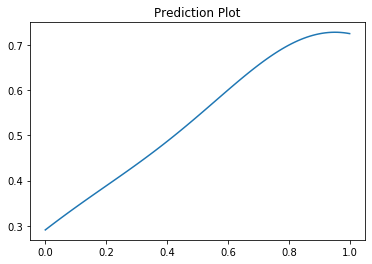

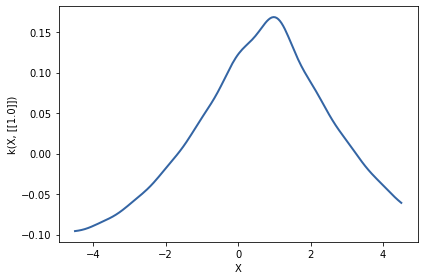

Iteration: 39 of 45


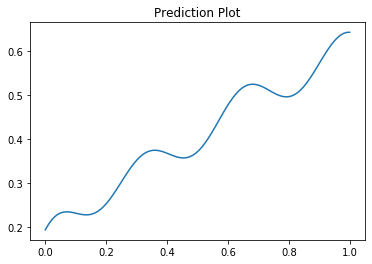

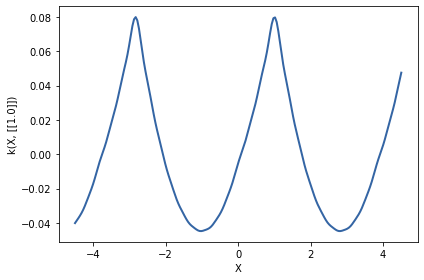

Iteration: 40 of 45


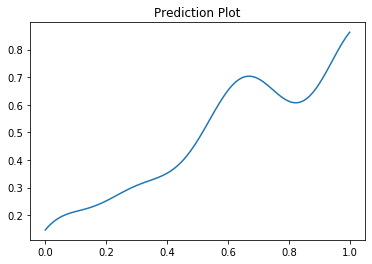

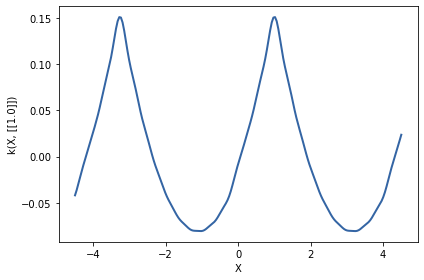

Iteration: 41 of 45


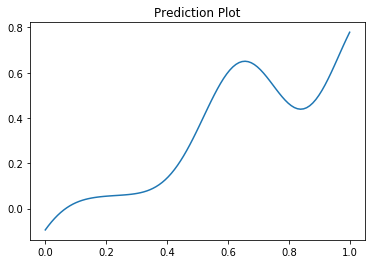

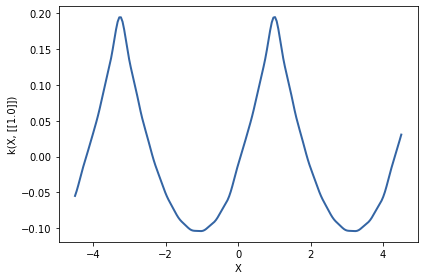

Iteration: 42 of 45


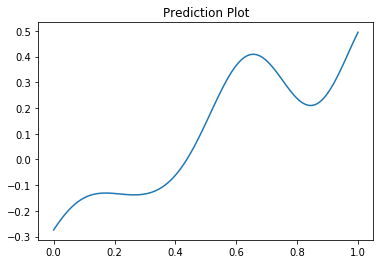

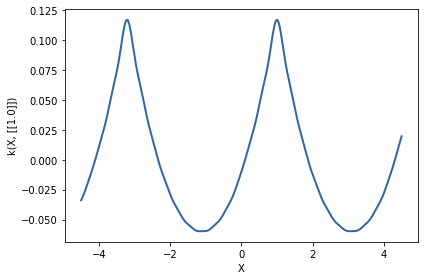

Iteration: 43 of 45


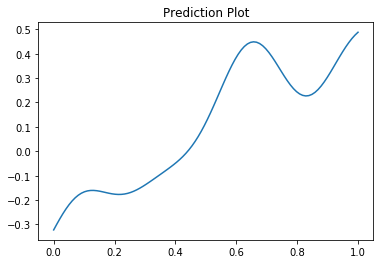

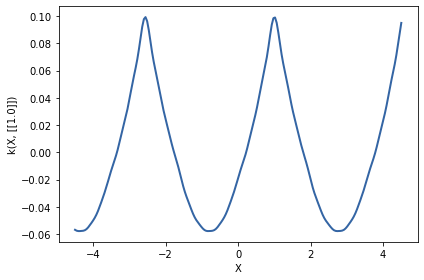

Iteration: 44 of 45


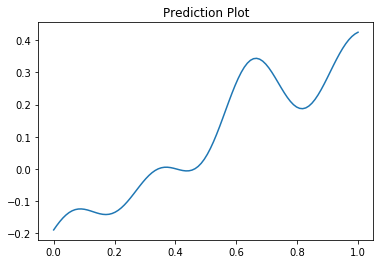

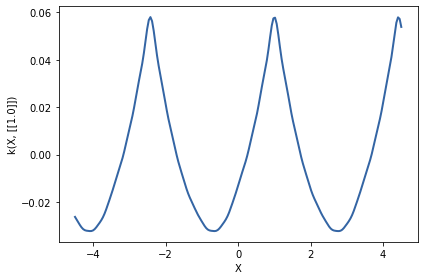

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0]


In [476]:
x = np.linspace(0,1,100).reshape(-1,1)
# Decision = pd.DataFrame(columns=['Id','Category'])
predicted = []
for r in range(rows):
    print(f'Iteration: {r} of {rows}')
    id_row = data.iloc[r,0]
    y = res.iloc[r,1:101].values[:,None]
    decision = run_model_2(x,y)
    predicted.append(decision)
#     Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
#     print(Decision)

# Decision.to_csv('submission_1.csv')
print(predicted)

In [477]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

#print(actual)
#print(predicted)

results = confusion_matrix(actual, predicted) 
print(results)
print('Accuracy Score :', accuracy_score(actual, predicted))
print ('The Report : ')
print (classification_report(actual, predicted))

[[25  4]
 [13  3]]
Accuracy Score : 0.6222222222222222
The Report : 
              precision    recall  f1-score   support

           0       0.66      0.86      0.75        29
           1       0.43      0.19      0.26        16

    accuracy                           0.62        45
   macro avg       0.54      0.52      0.50        45
weighted avg       0.58      0.62      0.57        45



In [396]:
# test_df = pd.read_csv("./data/test.csv")
# rows = test_df.shape[0]

# x = np.linspace(0,1,100).reshape(-1,1)
# Decision = pd.DataFrame(columns=['Id','Category'])
# for r in range(rows):
#     print(f'Iteration: {r} of {rows}')
#     id_row = test_df.iloc[r,0]
#     y = test_df.iloc[r,1:101].values[:,None]
#     decision = run_model_2(x,y)
#     Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
# #     print(Decision)

# Decision.to_csv('submission.csv')
# print(predicted)